In [9]:
import numpy as np
import pandas as pd
import math

import itertools

import os
import sys
sys.path.insert(0, "../")

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
from plotWafer import plotWafer
from train import emd

In [2]:
f_raw = '../data/signal/nElinks_5/ttbar_v11_eolNoise_Layer9_5Links.csv'

# if data not found, download from dropbox
if not os.path.isfile(f_raw):
    os.system('cd ../; wget -O data.tgz https://www.dropbox.com/s/owdfdxwb9rwrgyo/data.tgz?dl=1; tar -xvzf data.tgz; rm data.tgz')

calQ     = np.genfromtxt(f_raw, delimiter=',',usecols=[*range(0, 48)],skip_header=2000,max_rows=300)
sumQ     = calQ.sum(axis=1)
calQ     = calQ[sumQ>0]
sumQ     = sumQ[sumQ>0]
occ = (np.count_nonzero(calQ>1,axis=1))

# split train and validation so there is no overlap in samples whatsoever
train_indices = range(0, int(0.6*len(calQ)))
val_indices = range(int(0.6*len(calQ)), len(calQ))

idx1_train = np.array([i for i,j in itertools.product(train_indices,train_indices)])
idx2_train = np.array([j for i,j in itertools.product(train_indices,train_indices)])

X1_train = calQ[idx1_train]
X2_train = calQ[idx2_train]
y_train = np.array([emd(calQ[i],calQ[j]) for i, j in zip(idx1_train, idx2_train)])

idx1_val = np.array([i for i,j in itertools.product(val_indices,val_indices)])
idx2_val = np.array([j for i,j in itertools.product(val_indices,val_indices)])

X1_val = calQ[idx1_val]
X2_val = calQ[idx2_val]
y_val = np.array([emd(calQ[i],calQ[j]) for i, j in zip(idx1_val, idx2_val)])

print(X1_train.shape)
print(X2_train.shape)
print(y_train.shape)

print(X1_val.shape)
print(X2_val.shape)
print(y_val.shape)

(25600, 48)
(25600, 48)
(25600,)
(11664, 48)
(11664, 48)
(11664,)


In [3]:
i = 10
j = 13

fig, axs = plt.subplots(1,2, figsize=(10, 4))
axs[0].set(title='inputQ 1')
axs[1].set(title='inputQ 2')
minQ = min(min(calQ[i]),min(calQ[j]))
maxQ = max(max(calQ[i]),max(calQ[j]))
plotWafer(calQ[i], fig, axs[0], scale=(minQ,maxQ))
plotWafer(calQ[j], fig, axs[1], scale=(minQ,maxQ))
fig.suptitle('EMD = %.3f, occ = (%s, %s), sumQ = (%s, %s)'%(emd(calQ[i],calQ[j]),occ[i],occ[j], sumQ[i], sumQ[j]))
plt.show()

In [34]:
import tensorflow
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, BatchNormalization, Activation, Average
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1_l2

# make a simple fully connected model as a PoC
input1 = Input(shape=(48,), name='input_1')
input2 = Input(shape=(48,), name='input_2')
x = Concatenate(name='concat')([input1, input2])
x = Flatten(name='flatten')(x)
x = Dense(128, name='dense_1', kernel_regularizer=l1_l2(l1=0,l2=1e-4))(x)
x = BatchNormalization(name='batchnorm_1')(x)
x = Activation('relu', name='relu_1')(x)
x = Dense(128, name='dense_2', kernel_regularizer=l1_l2(l1=0,l2=1e-4))(x)
x = BatchNormalization(name='batchnorm_2')(x)
x = Activation('relu', name='relu_2')(x)
x = Dense(128, name='dense_3', kernel_regularizer=l1_l2(l1=0,l2=1e-4))(x)
x = BatchNormalization(name='batchnorm_3')(x)
x = Activation('relu', name='relu_3')(x)
output = Dense(1, name='output')(x)
model = Model(inputs=[input1, input2], outputs=output, name='base_model')
model.summary()

# make a model that enforces the symmetry of the EMD function by averging the outputs for swapped inputs
output = Average(name='average')([model((input1, input2)), model((input2, input1))])
sym_model = Model(inputs=[input1, input2], outputs=output, name='sym_model')
sym_model.summary()

Model: "base_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 48)]         0                                            
__________________________________________________________________________________________________
concat (Concatenate)            (None, 96)           0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 96)           0           concat[0][0]            

In [35]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
!mkdir -p models
callbacks = [ModelCheckpoint('models/emd_model_best.h5', monitor='val_loss', verbose=1, save_best_only=True),
             ModelCheckpoint('models/emd_model_last.h5', monitor='val_loss', verbose=1, save_last_only=True),
            ]
    
sym_model.compile(optimizer='adam', loss='msle', metrics=['mse', 'mae', 'mape', 'msle'])
history = sym_model.fit((X1_train, X2_train), y_train, 
                    validation_data=((X1_val, X2_val), y_val),
                    epochs=10, verbose=1, batch_size=32, callbacks=callbacks)

Epoch 1/10
800/800 [==============================] - 7s 7ms/step - loss: 0.5454 - mse: 13.8713 - mae: 2.6912 - mape: 27182597.8514 - msle: 0.5088 - val_loss: 0.1692 - val_mse: 4.5620 - val_mae: 1.6510 - val_mape: 52183552.0000 - val_msle: 0.1349

Epoch 00001: val_loss improved from inf to 0.16924, saving model to models/emd_model_best.h5

Epoch 00001: saving model to models/emd_model_last.h5
Epoch 2/10
800/800 [==============================] - 5s 7ms/step - loss: 0.1281 - mse: 3.3417 - mae: 1.4033 - mape: 31161414.4694 - msle: 0.0946 - val_loss: 0.1584 - val_mse: 4.5450 - val_mae: 1.5698 - val_mape: 48259228.0000 - val_msle: 0.1277

Epoch 00002: val_loss improved from 0.16924 to 0.15842, saving model to models/emd_model_best.h5

Epoch 00002: saving model to models/emd_model_last.h5
Epoch 3/10
800/800 [==============================] - 6s 7ms/step - loss: 0.1091 - mse: 2.7474 - mae: 1.2556 - mape: 27027057.0510 - msle: 0.0793 - val_loss: 0.1338 - val_mse: 3.3096 - val_mae: 1.3871 - va

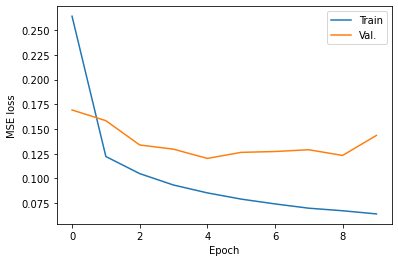

In [36]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val.')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.legend()

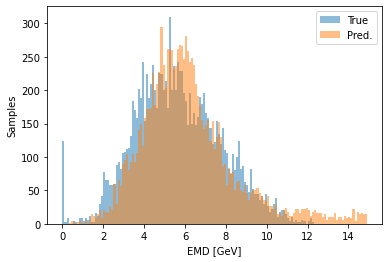

In [37]:
y_val_preds = sym_model.predict((X1_val, X2_val))
plt.figure()
plt.hist(y_val, alpha=0.5, bins=np.arange(0, 15, 0.1), label='True')
plt.hist(y_val_preds, alpha=0.5, bins=np.arange(0, 15, 0.1), label='Pred.')
plt.xlabel('EMD [GeV]')
plt.ylabel('Samples')
plt.legend()
plt.show()

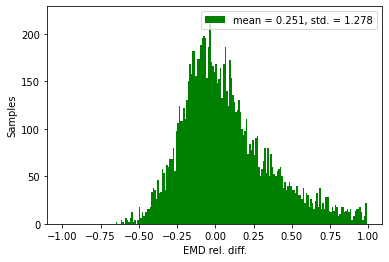

In [38]:
rel_diff = (y_val_preds[y_val>0].flatten()-y_val[y_val>0].flatten())/y_val[y_val>0].flatten()
plt.figure()
plt.hist(rel_diff, bins=np.arange(-1, 1, 0.01), color='green', label = 'mean = {:.3f}, std. = {:.3f}'.format(np.mean(rel_diff), np.std(rel_diff)))
plt.xlabel('EMD rel. diff.')
plt.ylabel('Samples')
plt.legend()
plt.show()

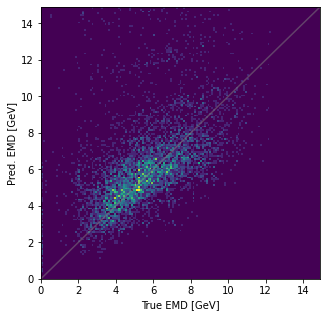

In [39]:
fig, ax = plt.subplots(figsize =(5, 5)) 
x_bins = np.arange(0, 15, 0.1)
y_bins = np.arange(0, 15, 0.1)
plt.hist2d(y_val.flatten(), y_val_preds.flatten(), bins=[x_bins,y_bins])
plt.plot([0, 15], [0, 15], color='gray', alpha=0.5)
ax.set_xlabel('True EMD [GeV]')
ax.set_ylabel('Pred. EMD [GeV]')
plt.show()